In [1]:
# Adapted from https://github.com/ArmanMaesumi/torchrbf/

import torch


'''
Radial basis functions:
'''
eps = 1e-7

def linear(r):
    return -r

def thin_plate_spline(r):
    r = torch.clamp(r, min=eps)
    return r**2 * torch.log(r)

def cubic(r):
    return r**3

def quintic(r):
    return -r**5

def multiquadric(r):
    return -torch.sqrt(r**2 + 1)

def inverse_multiquadric(r):
    return 1/torch.sqrt(r**2 + 1)

def inverse_quadratic(r):
    return 1/(r**2 + 1)

def gaussian(r):
    return torch.exp(-r**2)

RADIAL_FUNCS = {
   "linear": linear,
   "thin_plate_spline": thin_plate_spline,
   "cubic": cubic,
   "quintic": quintic,
   "multiquadric": multiquadric,
   "inverse_multiquadric": inverse_multiquadric,
   "inverse_quadratic": inverse_quadratic,
   "gaussian": gaussian
   }

SCALE_INVARIANT = {"linear", "thin_plate_spline", "cubic", "quintic"}

MIN_DEGREE = {
    "multiquadric": 0,
    "linear": 0,
    "thin_plate_spline": 1,
    "cubic": 1,
    "quintic": 2
    }

In [2]:
# Adapted from https://github.com/ArmanMaesumi/torchrbf/

import numpy as np
import contextlib
import warnings
import torch
import math

from itertools import combinations_with_replacement
# from .radial_fn import SCALE_INVARIANT, RADIAL_FUNCS, MIN_DEGREE


# SEED = 12345
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = True
# torch.set_num_threads(1)


class RBFInterpolator(torch.nn.Module):
    """
    Radial basis function interpolator in Pytorch. This is a port of
    the RBFInterpolator from scipy.interpolate.RBFInterpolator. With
    GPU acceleration, this is much faster than the scipy version.
    SciPy reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RBFInterpolator.html

    @param y: (n, d) tensor of data point coordinates
    @param d: (n, m) tensor of data vectors at y
    @param neighbors (optional): int [CURRENTLY UNIMPLEMENTED] specifies the
        number of neighbors to use for each interpolation point. If
        None, all points are used.
        Default is None.
    @param smoothing (optional): float or (n,) tensor of smoothing parameters
        Default is 0.0.
    @param kernel (optional): str, kernel function to use; one of
        ['linear', 'thin_plate_spline', 'cubic', 'quintic', 'gaussian'
        'multiquadric', 'inverse_multiquadric', 'inverse_quadratic']
        Default is 'thin_plate_spline'.
    @param epsilon (optional): float, shape parameter for the kernel function.
        If kernel is 'linear', 'thin_plate_spline', 'cubic', or
        'quintic', then default is 1.0 and can be ignored. Must be
        specified otherwise.
    @param degree (optional): int, degree of the polynomial added to the
        interpolation function. See scipy.interpolate.RBFInterpolator
        for more details.
    @param device (optional): str, specifies the default device to store tensors
        and perform interpolation.

    Returns a callable Torch Module that interpolates the data at given points.
    """

    def __init__(
        self,
        y,
        d,
        neighbors=None,
        smoothing=0.0,
        kernel="thin_plate_spline",
        epsilon=None,
        degree=None,
        device="cpu",
    ):
        super().__init__()

        if torch.backends.cuda.matmul.allow_tf32:
            warnings.warn(
                "TF32 is enabled, which may cause numerical issues in PyTorch RBFInterpolator. "
                "Consider disabling it with torch.backends.cuda.matmul.allow_tf32 = False",
                UserWarning,
            )

        self.device = device

        # init:
        if isinstance(y, np.ndarray):
            y = torch.from_numpy(y).to(device=device).float()

        if y.ndim != 2:
            raise ValueError("y must be a 2-dimensional tensor.")

        ny, ndim = y.shape
        if isinstance(d, np.ndarray):
            d = torch.from_numpy(d).to(device=device).float()

        if d.shape[0] != ny:
            raise ValueError(
                "The first dim of d must have the same length as the first dim of y."
            )

        d_shape = d.shape[1:]
        d = d.reshape((ny, -1))

        if isinstance(smoothing, (int, float)):
            smoothing = torch.full((ny,), smoothing, device=device).float()
        elif isinstance(smoothing, np.ndarray):
            smoothing = torch.Tensor(smoothing).to(device=device).float()
        elif not isinstance(smoothing, torch.Tensor):
            raise ValueError("`smoothing` must be a scalar or a 1-dimensional tensor.")

        kernel = kernel.lower()
        if kernel not in RADIAL_FUNCS:
            raise ValueError(f"Unknown kernel: {kernel}")

        if epsilon is None:
            if kernel in SCALE_INVARIANT:
                epsilon = 1.0
            else:
                raise ValueError("Must specify `epsilon` for this kernel.")
        else:
            epsilon = float(epsilon)

        min_degree = MIN_DEGREE.get(kernel, -1)
        if degree is None:
            degree = max(min_degree, 0)
        else:
            degree = int(degree)
            if degree < -1:
                raise ValueError("`degree` must be at least -1.")
            elif degree < min_degree:
                warnings.warn(
                    f"`degree` is too small for this kernel. Setting to {min_degree}.",
                    UserWarning,
                )

        if neighbors is None:
            nobs = ny
        else:
            raise ValueError("neighbors currently not supported")

        powers = monomial_powers(ndim, degree).to(device=device)
        if powers.shape[0] > nobs:
            raise ValueError("The data is not compatible with the requested degree.")

        if neighbors is None:
            shift, scale, coeffs = solve(y, d, smoothing, kernel, epsilon, powers)
            self.register_buffer("_shift", shift)
            self.register_buffer("_scale", scale)
            self.register_buffer("_coeffs", coeffs)

        self.register_buffer("y", y)
        self.register_buffer("d", d)
        self.register_buffer("smoothing", smoothing)
        self.register_buffer("powers", powers)

        self.d_shape = d_shape
        self.neighbors = neighbors
        self.kernel = kernel
        self.epsilon = epsilon

    def forward(self, x: torch.Tensor):
        """
        Returns the interpolated data at the given points `x`.

        @param x: (n, d) tensor of points at which to query the interpolator
        @param use_grad (optional): bool, whether to use Torch autograd when
            querying the interpolator. Default is False.

        Returns a (n, m) tensor of interpolated data.
        """
        if x.ndim != 2:
            raise ValueError("`x` must be a 2-dimensional tensor.")

        nx, ndim = x.shape
        if ndim != self.y.shape[1]:
            raise ValueError(
                "Expected the second dim of `x` to have length "
                f"{self.y.shape[1]}."
            )

        kernel_func = RADIAL_FUNCS[self.kernel]

        yeps = self.y * self.epsilon
        xeps = x * self.epsilon
        xhat = (x - self._shift) / self._scale

        kv = kernel_vector(xeps, yeps, kernel_func)
        p = polynomial_matrix(xhat, self.powers)
        vec = torch.cat([kv, p], dim=1)
        out = torch.matmul(vec, self._coeffs)
        out = out.reshape((nx,) + self.d_shape)
        return out


def kernel_vector(x, y, kernel_func):
    """Evaluate radial functions with centers `y` for all points in `x`."""
    return kernel_func(torch.cdist(x, y, compute_mode="use_mm_for_euclid_dist"))


def polynomial_matrix(x, powers):
    """Evaluate monomials at `x` with given `powers`"""
    x_ = torch.repeat_interleave(x, repeats=powers.shape[0], dim=0)
    powers_ = powers.repeat(x.shape[0], 1)
    return torch.prod(x_**powers_, dim=1).view(x.shape[0], powers.shape[0])


def kernel_matrix(x, kernel_func):
    """Returns radial function values for all pairs of points in `x`."""
    return kernel_func(torch.cdist(x, x, compute_mode="use_mm_for_euclid_dist"))


def monomial_powers(ndim, degree):
    """Return the powers for each monomial in a polynomial.

    Parameters
    ----------
    ndim : int
        Number of variables in the polynomial.
    degree : int
        Degree of the polynomial.

    Returns
    -------
    (nmonos, ndim) int ndarray
        Array where each row contains the powers for each variable in a
        monomial.

    """
    nmonos = math.comb(degree + ndim, ndim)
    out = torch.zeros((nmonos, ndim), dtype=torch.int32)
    count = 0
    for deg in range(degree + 1):
        for mono in combinations_with_replacement(range(ndim), deg):
            for var in mono:
                out[count, var] += 1
            count += 1

    return out


def build(y, d, smoothing, kernel, epsilon, powers):
    """Build the RBF linear system"""

    p = d.shape[0]
    s = d.shape[1]
    r = powers.shape[0]
    kernel_func = RADIAL_FUNCS[kernel]

    mins = torch.min(y, dim=0).values
    maxs = torch.max(y, dim=0).values
    shift = (maxs + mins) / 2
    scale = (maxs - mins) / 2

    scale[scale == 0.0] = 1.0

    yeps = y * epsilon
    yhat = (y - shift) / scale

    lhs = torch.empty((p + r, p + r), device=d.device).float()
    lhs[:p, :p] = kernel_matrix(yeps, kernel_func)
    lhs[:p, p:] = polynomial_matrix(yhat, powers)
    lhs[p:, :p] = lhs[:p, p:].T
    lhs[p:, p:] = 0.0
    lhs[:p, :p] += torch.diag(smoothing)

    rhs = torch.empty((r + p, s), device=d.device).float()
    rhs[:p] = d
    rhs[p:] = 0.0

    return lhs, rhs, shift, scale


def solve(y, d, smoothing, kernel, epsilon, powers):
    """Build then solve the RBF linear system"""

    lhs, rhs, shift, scale = build(y, d, smoothing, kernel, epsilon, powers)
    try:
        coeffs = torch.linalg.solve(lhs, rhs)
    except RuntimeError:  # singular matrix
        if coeffs is None:
            msg = "Singular matrix."
            nmonos = powers.shape[0]
            if nmonos > 0:
                pmat = polynomial_matrix((y - shift) / scale, powers)
                rank = torch.linalg.matrix_rank(pmat)
                if rank < nmonos:
                    msg = (
                        "Singular matrix. The matrix of monomials evaluated at "
                        "the data point coordinates does not have full column "
                        f"rank ({rank}/{nmonos})."
                    )

            raise ValueError(msg)

    return shift, scale, coeffs

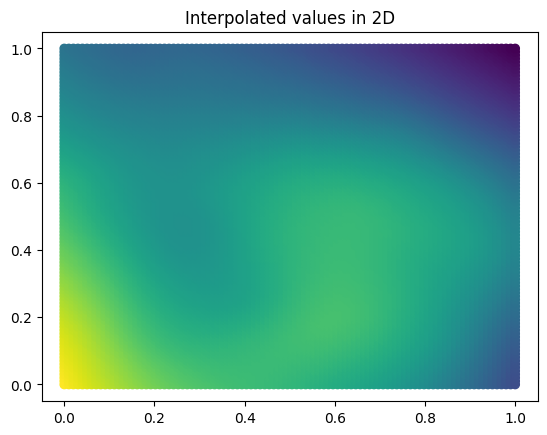

In [3]:
import torch
import matplotlib.pyplot as plt

y = torch.rand(100, 2) # Data coordinates
d = torch.rand(100, 3) # Data vectors at each point

interpolator = RBFInterpolator(y, d, smoothing=1.0, kernel='thin_plate_spline')

# Query coordinates (100x100 grid of points)
x = torch.linspace(0, 1, 100)
y = torch.linspace(0, 1, 100)
grid_points = torch.meshgrid(x, y, indexing='ij')
grid_points = torch.stack(grid_points, dim=-1).reshape(-1, 2)

# Query RBF on grid points
interp_vals = interpolator(grid_points)

# Plot the interpolated values in 2D
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=interp_vals[:, 0])
plt.title('Interpolated values in 2D')
plt.show()

In [4]:
from lips import get_root_path
from lips.dataset import airfransDataSet
from lips.dataset.airfransDataSet import AirfRANSDataSet
from lips.benchmark.airfransBenchmark import AirfRANSBenchmark
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from torch import nn

from airfrans.simulation import Simulation
import pyvista as pv

import xgboost as xgb

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
# indicate required paths
LIPS_PATH = get_root_path()
DIRECTORY_NAME = '../../Airfrans/Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = LIPS_PATH + "lips_logs.log"
BENCH_CONFIG_PATH = os.path.join("../../Kit", "airfoilConfigurations","benchmarks","confAirfoil.ini") #Configuration file related to the benchmark
SIM_CONFIG_PATH = os.path.join("../../Kit", "airfoilConfigurations","simulators","torch_fc.ini") #Configuration file re
# print(BENCH_CONFIG_PATH)

# Scalers
PRESS_SCALE = 1600.0
TURB_SCALE = 0.01
SPEED_SCALE = 75.0
DEFAULT_SCALE = 1.0


In [6]:
benchmark=AirfRANSBenchmark(benchmark_path = DIRECTORY_NAME,
                            config_path = BENCH_CONFIG_PATH,
                            benchmark_name = BENCHMARK_NAME,
                            log_path = LOG_PATH)
benchmark.load(path=DIRECTORY_NAME)

Loading dataset (task: reynolds, split: test): 100%|██████████| 496/496 [01:10<00:00,  7.07it/s]


In [7]:
# Create normalizing constants
MEANS = {}
STDS = {}

for var in ['x-position', 'y-position', 'x-inlet_velocity', 'x-velocity', 'pressure', 'turbulent_viscosity']:
    MEANS[var] = np.mean(benchmark.train_dataset.data[var])
    STDS[var] = np.std(benchmark.train_dataset.data[var])

MEANS['speed'] = MEANS['x-inlet_velocity']
STDS['speed'] = STDS['x-inlet_velocity']
MEANS['position'] = 0.0
STDS['position'] = 1.0

for var in ['x-position', 'y-position', 'x-inlet_velocity', 'x-velocity']:
    MEANS.pop(var, None)
    STDS.pop(var, None)

print(MEANS)
print(STDS)

x_means = np.zeros(2, dtype=np.float32)
x_stds = np.zeros(2, dtype=np.float32)
y_means = np.zeros(4, dtype=np.float32)
y_stds = np.zeros(4, dtype=np.float32)

for i, var in zip(range(2), ['position', 'speed']):        
    x_means[i] = MEANS[var]
    x_stds[i] = STDS[var]

for i, var in zip(range(4), ['position', 'speed', 'pressure', 'turbulent_viscosity']):        
    y_means[i] = MEANS[var]
    y_stds[i] = STDS[var]

MEANS['pressure'] = 0.0
MEANS['turbulent_viscosity'] = 0.0


{'pressure': -395.22959540860137, 'turbulent_viscosity': 0.0008392954292084482, 'speed': 63.15423170302567, 'position': 0.0}
{'pressure': 2425.738434726353, 'turbulent_viscosity': 0.0030420989011928183, 'speed': 8.487422521188462, 'position': 1.0}


In [8]:
# Edge functions

import torch
from torch_geometric.data import Data

# Create label and data array for single edge
def make_edge(a, b):
    label = str(a) + '_' + str(b)
    return label, np.array([a,b], dtype=int)


# Line from a to b
def delta_vector(from_v, to_v):
    return to_v-from_v

def angle_off_x_axis(a):
    # Note that both vectors begin at the origin, so we actually want them compared vs. [1,0]
    # if len(a.shape) < 2:
    #     a = np.expand_dims(a, 1)
    if len(a.shape) < 2:
        norm = np.linalg.norm(a)
        out = np.ones_like(norm)
        out = np.arccos(np.divide(a.dot(np.array([1,0])),norm))

    else:
        norm = np.linalg.norm(a, axis=1)
        out = np.ones_like(norm)
        out[np.where(norm > 0)] = np.arccos(np.divide(np.squeeze(a[np.where(norm > 0)]).dot(np.array([1,0])),np.squeeze(norm[np.where(norm > 0)])))
    return out

# Create all edges
def make_edges(sim):
    cells = sim.internal.cells_dict[9]

    edge_dict = {}
    for cell in cells:
        # Create fully connected mesh, including diagonals
        for i in range(0, 4):
            for j in range(0, 4):
                if i == j: 
                    continue
                label, data = make_edge(cell[i], cell[j])
                if label not in edge_dict:
                    edge_dict[label] = data # Push the edge

    # Store de-duplicated bidirectional edges in numpy format
    edge_index = np.zeros((2,len(edge_dict)), dtype=np.intc)
    edge_features = np.zeros((len(edge_dict),2), dtype=np.float32)

    for i, edge in zip(range(0, len(edge_dict)), edge_dict.values()):
        edge_index[:,i] = edge
        edge_features[i,0] = np.sqrt(np.sum([sim.position[edge[0]]**2, sim.position[edge[1]]**2]))
        # print(angle_off_x_axis(delta_vector(sim.position[edge[0]], sim.position[edge[1]])))
        edge_features[i,1] = angle_off_x_axis(delta_vector(sim.position[edge[0]], sim.position[edge[1]]))
    
    return edge_index, edge_features

In [9]:
# Dataset preparation 

from tqdm import tqdm
from torch_geometric.data import InMemoryDataset, Dataset
import os
from scipy.spatial.distance import cdist


class AirFransGeo():
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
        self.data = []
        for i in tqdm(indices):
            sim = Simulation(DIRECTORY_NAME, self.dataset.extra_data['simulation_names'][i,0])
            # sim = extract_dataset_by_simulation('sim', self.dataset, i)
            # global_x = sim.input_velocity # These are global inputs for each node in the mesh
            inlet_speed = np.linalg.norm(sim.input_velocity, axis=1)
            inlet_theta = angle_off_x_axis(sim.input_velocity)

            # Negate the angles if y < 0
            inlet_theta[np.where(sim.input_velocity[:,1] < 0)] *= -1.0

            # X position
            position = (sim.position - MEANS['position']) / STDS['position']

            # global_x = (global_x - MEANS['speed']) / STDS['speed']
            inlet_speed = (inlet_speed - MEANS['speed']) / STDS['speed']

            # Find closest airfoil points
            surface = np.hstack([sim.position[sim.surface], sim.normals[sim.surface]])
            dists = cdist(sim.position, surface[:,:2], metric='euclidean')
            best_idx = np.argmin(dists,axis=1).T.tolist()
            closest_surfaces = np.take(surface, best_idx, axis=0)

            # Vector to closest airfoil point
            vector_to_surface = delta_vector(sim.position, closest_surfaces[:,:2])
            vector_to_surface = (vector_to_surface - MEANS['position']) / STDS['position']

            # Angle (relative to x-axis) to closest airfoil point
            surface_theta = angle_off_x_axis(delta_vector(sim.position, closest_surfaces[:,:2]))

            # Airfoil distance
            surface_distance = (sim.sdf - MEANS['position']) / STDS['position']

            # Rotate normal vector 90 degrees, take the angle in the positive x direction
            # rotated_normal = rotate(closest_surfaces[:,2:], -np.pi/2)
            # rotated_normal[np.where(rotated_normal[:,0]<0)] = rotate(rotated_normal[np.where(rotated_normal[:,0]<0)], np.pi)
            # assert(np.min(rotated_normal[:,0]) >= 0.0)
            # flow_theta = angle_off_x_axis(rotated_normal)
            # flow_theta[np.where(rotated_normal[:,1] < 0)] = -1 * np.abs(flow_theta[np.where(rotated_normal[:,1] < 0)])

            # Is_airfoil
            is_airfoil = sim.surface.astype(np.float32)

            # Y Outlet speed
            outlet_speed = np.linalg.norm(sim.velocity, axis=1)
            outlet_speed = (outlet_speed - MEANS['speed']) / STDS['speed']

            # Y Outlet theta
            outlet_theta = angle_off_x_axis(sim.velocity)
            outlet_theta[np.where(sim.velocity[:,1] < 0)] *= -1.0

            # Y Pressure
            outlet_pressure = (sim.pressure - MEANS['pressure']) / STDS['pressure']

            # Y Turb
            outlet_turb = (sim.nu_t - MEANS['turbulent_viscosity']) / STDS['turbulent_viscosity']

            # X and Y coordinates of each point as well as normals (when on airfoil)
            x = np.hstack([position, np.expand_dims(inlet_speed,1), 
                        np.expand_dims(inlet_theta,1), np.expand_dims(is_airfoil,1),
                         vector_to_surface, np.expand_dims(surface_theta,1), surface_distance]) #np.expand_dims(flow_theta, 1)]) 
            y = np.hstack([np.expand_dims(outlet_speed,1), np.expand_dims(outlet_theta,1), outlet_pressure, outlet_turb])
            edge_index, edge_attr = make_edges(sim)            

            instance = Data(x=torch.from_numpy(x.astype(np.float32)), edge_index=torch.from_numpy(edge_index),
                    edge_attr=torch.from_numpy(edge_attr.astype(np.float32)), y=torch.from_numpy(y.astype(np.float32)), 
                    pos=torch.from_numpy(sim.position.astype(np.float32)))
            self.data.append(instance)

    def len():
        return len(indices)

    def get(self,index):
        return self.data[index]

# Make train and CV splits
cv_indices = list(np.array(range(1,int(103/5)),dtype=np.intc)*5)
train_indices = []
for i in range(0,103):
    if i not in cv_indices:
        train_indices.append(i)


In [10]:
# Load datasets

import pickle

TRUNCATED = True
REFRESH = True

if os.path.exists('train.pkl') and not REFRESH:
    file = open('train.pkl', 'rb')
    train = pickle.load(file)
    file.close()
    file = open('cv.pkl', 'rb')
    cv = pickle.load(file)
    file.close()
else:

    if TRUNCATED:
        train = AirFransGeo(benchmark.train_dataset, train_indices[:1])
        cv = AirFransGeo(benchmark.train_dataset, cv_indices[:1])
    else:
        train = AirFransGeo(benchmark.train_dataset, train_indices)
        cv = AirFransGeo(benchmark.train_dataset, cv_indices)

        # Save files
        file = open(os.path.join('train.pkl'), 'wb')
        pickle.dump(train, file)
        file.close()
        file = open(os.path.join('cv.pkl'), 'wb')
        pickle.dump(cv, file)
        file.close()


100%|██████████| 1/1 [00:12<00:00, 12.07s/it]


In [11]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 1

FEATS = 9
NODES = 16
OUTPUTS = 4

CONV_LAYERS = 8

activation = 'GELU'

train_loader = DataLoader(train.data, shuffle=False, batch_size=BATCH_SIZE)
cv_loader = DataLoader(cv.data, shuffle=False, batch_size=BATCH_SIZE)

device = torch.device('cuda')

In [12]:
for first in train_loader:
    break

first

DataBatch(x=[170180, 9], edge_index=[2, 1354312], edge_attr=[1354312, 2], y=[170180, 4], pos=[170180, 2], batch=[170180], ptr=[2])

In [13]:
# Convert to true values
x = (first.pos*STDS['position'] + MEANS['position']).numpy()

y_true = first.y.numpy().copy()
y = y_true.copy()

speed = y[:,0]*STDS['speed'] + MEANS['speed']

pred_y_vel = np.zeros_like(y[:,1])
true_y_vel = np.zeros_like(y[:,1])

pred_x_vel = (np.cos(2*np.pi + y[:,1]))*speed
pred_y_vel[np.where(y[:,1]<=0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y[np.where(y[:,1]<=0),1]))),speed[np.where(y[:,1]<=0)])
pred_y_vel[np.where(y[:,1]>0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y[np.where(y[:,1]>0),1]))),speed[np.where(y[:,1]>0)])

true_x_vel = (np.cos(2*np.pi + y_true[:,1]))*speed
true_y_vel[np.where(y_true[:,1]<=0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y_true[np.where(y_true[:,1]<=0),1]))),speed[np.where(y_true[:,1]<=0)])
true_y_vel[np.where(y_true[:,1]>0)] = np.multiply((np.sin(2*np.pi + np.squeeze(y_true[np.where(y_true[:,1]>0),1]))),speed[np.where(y_true[:,1]>0)])

y[:,0] = pred_x_vel
y[:,1] = pred_y_vel
y[:,2] = (y[:,2]*STDS['pressure']) + MEANS['pressure']
y[:,3] = (y[:,3]*STDS['turbulent_viscosity']) + MEANS['turbulent_viscosity']

y_true[:,0] = true_x_vel
y_true[:,1] = true_y_vel
y_true[:,2] = (y_true[:,2]*STDS['pressure']) + MEANS['pressure']
y_true [:,3] = (y_true[:,3]*STDS['turbulent_viscosity']) + MEANS['turbulent_viscosity']

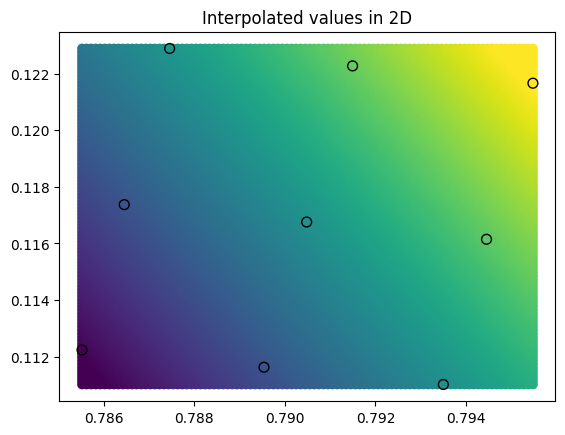

In [14]:
import matplotlib.pyplot as plt

center = x[45415, :2]
# delta = 0.0069
# delta = 0.0069
delta = 0.0069

# indices = np.where(np.logical_and(np.logical_and(np.greater_equal(x[:,0], center[0]-delta), np.less_equal(x[:,0], center[0]+delta)), 
#             np.logical_and(np.greater_equal(x[:,1], center[1]-delta), np.less_equal(x[:,1], center[1]+delta))))

# index_list = [45394, 45415, 45432, 45438, 45458, 45484, 45331, 45358, 45390]

indices = [[45415, 45224, 45225, 45414, 45226, 45416, 45605, 45604, 45606]]

# Code to get indices
# torch.gather(first.edge_index, 1, torch.unsqueeze(torch.where(first.edge_index[0,:]==45415)[0], 0).repeat(2,1)).numpy()


small_x = x[indices[0],:2]
small_y = y_true[indices[0],:]

x_min = np.min(small_x, axis=0)
x_max = np.max(small_x, axis=0)
y_min = np.min(small_y[:,2])
y_max = np.max(small_y[:,2])

interpolator = RBFInterpolator(small_x, small_y, smoothing=1.0, kernel='cubic')
# interpolator = RBFInterpolator(small_x, small_y, smoothing=1.0, kernel='gaussian', epsilon=0.0001)

# Query coordinates (100x100 grid of points)
interx = torch.linspace(x_min[0], x_max[0], 100)
intery = torch.linspace(x_min[1], x_max[1], 100)
grid_points = torch.meshgrid(interx, intery, indexing='ij')
grid_points = torch.stack(grid_points, dim=-1).reshape(-1, 2)

# Query RBF on grid points
interp_vals = interpolator(grid_points)

# Plot the interpolated values in 2D
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=interp_vals[:,2], vmin=y_min, vmax=y_max)
plt.scatter(*small_x.T, c=small_y[:,2], s=50, ec='k', vmin=y_min, vmax=y_max)
plt.title('Interpolated values in 2D')
plt.show()

# fig, ax = plt.subplots()
# ax.pcolormesh(*grid_points.T, interp_vals[:, 2], vmin=-0.25, vmax=0.25, shading='gouraud')
# p = ax.scatter(*small_x.T, c=small_y[:,2], s=50, ec='k', vmin=-0.25, vmax=0.25)
# fig.colorbar(p)
# plt.show()

In [15]:
T = 298.15

MOL = np.array(28.965338e-3) # Air molar weigth in kg/mol
P_ref = np.array(1.01325e5) # Pressure reference in Pa
RHO = P_ref*MOL/(8.3144621*T) # Specific mass of air at temperature T
NU = -3.400747e-6 + 3.452139e-8*T + 1.00881778e-10*T**2 - 1.363528e-14*T**3 # Approximation of the kinematic viscosity of air at temperature T
C = 20.05*np.sqrt(T) # Approximation of the sound velocity of air at temperature T   

In [16]:
# # new_x = interx[50]
# # new_y = interx[50]
# new_x = torch.from_numpy(np.array(x[45415, 0]).copy())
# new_y = torch.from_numpy(np.array(x[45415, 1]).copy())
# new_x.requires_grad = True
# new_y.requires_grad = True

# new_interp = interpolator(torch.unsqueeze(torch.stack([new_x, new_y]), 0))
# # print(new_interp)
# # new_interp[:,2].backward(retain_graph=True)
# # # new_x.grad
# # new_interp[:,3].backward(retain_graph=True)
# # new_interp[:,2].backward(retain_graph=True)
# # new_x.zero_grad()
# # new_interp[:,2].backward(retain_graph=True)

# def val(t):
#     return t.detach().numpy().item()

# for var, index in zip(['vx', 'vy', 'p', 'nu'], range(4)):
#     exec('d_' + var + '= torch.autograd.grad(new_interp[:,' + str(index) + '], [new_x, new_y], retain_graph=True, create_graph=True)')
#     exec('d_' + var + '_dx = val(d_' + var + '[0])')
#     exec('d_' + var + '_dy = val(d_' + var + '[1])')

#     exec('d2_' + var + ' = torch.autograd.grad(d_' + var +'[0], [new_x, new_y], retain_graph=True, create_graph=True)')
#     exec('d2_' + var + '_d2x = val(d2_' + var + '[0])')
#     exec('d2_' + var + '_dxdy = val(d2_' + var + '[1])')

#     exec('d2_' + var + ' = torch.autograd.grad(d_' + var +'[1], [new_x, new_y], retain_graph=True, create_graph=True)')
#     exec('d2_' + var + '_d2y = val(d2_' + var + '[1])')

# # print(d_vx_dx)
# # print(d_vx_dy)
# # print(d_vy_dx)
# # print(d_vy_dy)

# div = d_vx_dx + d_vy_dy
# print(div)
# # print(div)  #### ROCK ON!!!!

# lhs = new_interp[:, 0]*d_vx_dx + new_interp[:, 1]*d_vx_dy
# rhs = -d_p_dx + (NU + new_interp[:, 3])*(d2_vx_d2x + d2_vx_d2y)
# print(lhs)
# print(rhs) 
# # print(new_interp[:, 3])

# # ROCK ON ROCK ON ROCK ON!!!!

# print(abs(lhs-rhs))

# lhs = new_interp[:, 0]*d_vy_dx + new_interp[:, 1]*d_vy_dy
# rhs = -d_p_dy + (NU + new_interp[:, 3])*(d2_vy_d2x + d2_vy_d2y)
# print(lhs)
# print(rhs) 
# # print(new_interp[:, 3])

# # ROCK ON ROCK ON ROCK ON!!!

# print(abs(lhs-rhs))


In [ ]:
from tqdm import tqdm

def phys_error(index, x, edge_index, y, device):

    # Find all neighbors
    indices = torch.gather(edge_index, 1, torch.unsqueeze(torch.where(edge_index[0,:]==index)[0], 0).repeat(2,1)).numpy()

    # If we have no neighbors, this is probably an airfoil node
    if len(indices) == 0:
        return torch.tensor(0.0, device=device), torch.tensor(0.0, device=device), torch.tensor(0.0, device=device)

    indices = np.concatenate((np.array([index]), indices[1])) # Add the main index back in

    # Cubic interpolation over neighbors
    small_x = torch.tensor(x[indices,:2]).to(device)
    small_y = torch.tensor(y[indices,:]).to(device)
    interpolator = RBFInterpolator(small_x, small_y, smoothing=1.0, kernel='cubic', device=device)

    # Do I need this?
    new_x = torch.from_numpy(np.array(x[index, 0]).copy()).to(device)
    new_y = torch.from_numpy(np.array(x[index, 1]).copy()).to(device)
    new_x.requires_grad = True
    new_y.requires_grad = True

    # Calculate interpolated values at the key point
    new_interp = interpolator(torch.unsqueeze(torch.stack([new_x, new_y]), 0))

    # Calculate needed derivatives
    
    # VX
    d_vx = torch.autograd.grad(new_interp[:,0], [new_x, new_y], retain_graph=True, create_graph=True)
    d_vx_dx = d_vx[0]
    d_vx_dy = d_vx[1]

    d2_vx = torch.autograd.grad(d_vx[0], [new_x, new_y], retain_graph=True, create_graph=True)
    d2_vx_d2x = d2_vx[0]

    d2_vx = torch.autograd.grad(d_vx[1], [new_x, new_y], retain_graph=True, create_graph=True)
    d2_vx_d2y = d2_vx[1]

    # VY
    d_vy = torch.autograd.grad(new_interp[:,1], [new_x, new_y], retain_graph=True, create_graph=True)
    d_vy_dx = d_vy[0]
    d_vy_dy = d_vy[1]

    d2_vy = torch.autograd.grad(d_vy[0], [new_x, new_y], retain_graph=True, create_graph=True)
    d2_vy_d2x = d2_vy[0]

    d2_vy = torch.autograd.grad(d_vy[1], [new_x, new_y], retain_graph=True, create_graph=True)
    d2_vy_d2y = d2_vy[1]

    # P
    d_p = torch.autograd.grad(new_interp[:,2], [new_x, new_y], retain_graph=True, create_graph=True)
    d_p_dx = d_p[0]
    d_p_dy = d_p[1]

    # Conservation of mass error term (should be 0)
    mass_err = torch.abs(torch.add(d_vx_dx, d_vy_dy))

    # Momentum error term (x component)
    lhs = new_interp[:, 0]*d_vx_dx + new_interp[:, 1]*d_vx_dy
    rhs = -d_p_dx + (NU + new_interp[:, 3])*(d2_vx_d2x + d2_vx_d2y)
    mom_x_err = torch.abs(lhs-rhs)

    # Momentum error term (y component)
    lhs = new_interp[:, 0]*d_vy_dx + new_interp[:, 1]*d_vy_dy
    rhs = -d_p_dy + (NU + new_interp[:, 3])*(d2_vy_d2x + d2_vy_d2y)
    mom_y_err = torch.abs(lhs-rhs)

    return mass_err, mom_x_err, mom_y_err

surface = torch.where(first.x[:,4]!=0.0)[0]

# Remove surface edges first
edge_mask = ~torch.isin(first.edge_index[:,:], surface)
non_surface = torch.any(edge_mask, dim=0)
edge_index = first.edge_index[:,non_surface]

for i in tqdm(range(x.shape[0])):
    phys_error(i, x, edge_index, y_true, 'cuda')

(tensor(0.0182, device='cuda:0', grad_fn=<AbsBackward0>),
 tensor([0.0347], device='cuda:0', grad_fn=<AbsBackward0>),
 tensor([0.2135], device='cuda:0', grad_fn=<AbsBackward0>))